In [23]:
import torch 
import numpy as np
import pandas as pd
import skimage 
import src

from src.optimal_transport_modules import icnn_modules as icnn
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from PIL import Image
from IPython.display import display
from matplotlib import pyplot as plt

In [24]:
%matplotlib inline

# Evaluation of Experiments 
In this notebook we set up the evaluation of our experiments. We also implement the visualisation. 

## TO DOs
* ~~import CelebA .csv~~
* ~~compute percentage of men and women for any other categories~~
    * ~~visualisation~~
* ~~compute distribution of our ranking score for every category~~
    * ~~visualisation~~
* ~~print the top 36 images~~
* ~~import features space after TSNE~~
    * ~~print such a space with points colored with a heatmap according with the ranking score~~
* import the result of partial clustering 
    * print the centroid for every cluster

In [25]:
# paths 
celebA_csv = "../data/celeba/celebA_female.csv"
results_folder = "../results"
models_folder = results_folder + "/Results_CelebA_ResNet18/input_dim_512/init_trunc_inv_sqrt/layers_5/neuron_512/lambda_cvx_0.1_mean_0.0/optim_Adamlr_0.001betas_0.5_0.99/gen_5/batch_300/trial_1_last_inp_qudr/storing_models"

In [26]:
# other inputs
# final epoch of ICNN training
final_epoch = 17

# GPU acceleration
cuda = torch.cuda.is_available()
mps = torch.backends.mps.is_available()

In [27]:
cuda

False

In [28]:
# import celebA data
df = pd.read_csv(celebA_csv)

df.head()

,index,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,values,values1,values_resnet18
0,0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,6629.578613,-828.345459,98403.103900
1,1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,1,6035.264160,-639.834961,104507.229389
2,3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,...,-1,1,-1,1,1,-1,1,11405.099609,-720.791931,83298.700580
3,4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,1,11328.725586,-594.776306,73223.356830
4,5,000006.jpg,-1,1,1,-1,-1,-1,1,-1,...,1,1,-1,1,-1,-1,1,3073.829590,-995.757385,107948.951923


In [29]:
# import feature extractor
#features = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

We compute the percentage of men and women for each attribute in CelebA.

In [30]:
# for every attribute, compute the percentage of men and women with that attribute
#n_male = len(df[df["Male"] == 1])
n_female = len(df[df["Male"] == -1])

bias = dict()

for col in df.columns:
    #n_male_col = len(df[(df["Male"] == 1) & (df[col] == 1)])
    n_female_col = len(df[(df["Male"] == -1) & (df[col] == 1)])
    
    bias[col] = {"Female" : n_female_col/n_female}

bias.pop("image_id")
bias.pop("Male")

{'Female': 0.0}

In [31]:
# function that saves barplots
def make_barplot(path, column, values):
    plt.bar(["Male", "Female"], [val for key, val in values.items()], color = ["mediumseagreen", "mediumpurple"])
    plt.title(column)
    plt.savefig(path + "/{}.jpeg".format(column))

In [32]:
# save the barplots
for col, values in bias.items():
    make_barplot(results_folder + "/barplots_celeba", col, values)
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [33]:
bias.items()

dict_items([('index', {'Female': 8.462742774933356e-06}), ('5_o_Clock_Shadow', {'Female': 0.0001692548554986671}), ('Arched_Eyebrows', {'Female': 0.419557398552871}), ('Attractive', {'Female': 0.6791689586595016}), ('Bags_Under_Eyes', {'Female': 0.10190834849574747}), ('Bald', {'Female': 0.00014386662717386705}), ('Bangs', {'Female': 0.20106630558964161}), ('Big_Lips', {'Female': 0.30132441924427705}), ('Big_Nose', {'Female': 0.1022722464350696}), ('Black_Hair', {'Female': 0.19731731054034612}), ('Blond_Hair', {'Female': 0.23893707950746837}), ('Blurry', {'Female': 0.046367367663859856}), ('Brown_Hair', {'Female': 0.24359158803368172}), ('Bushy_Eyebrows', {'Female': 0.06923369864172979}), ('Chubby', {'Female': 0.012186349595904032}), ('Double_Chin', {'Female': 0.00968137773452376}), ('Eyeglasses', {'Female': 0.022976346633944062}), ('Goatee', {'Female': 0.00011001565607413363}), ('Gray_Hair', {'Female': 0.010696906867515761}), ('Heavy_Makeup', {'Female': 0.6614141243176913}), ('High_Ch

In [34]:
df.values_resnet18

0          98403.103900
1         104507.229389
2          83298.700580
3          73223.356830
4         107948.951923
              ...      
118160    100865.720111
118161    106736.020160
118162    106040.588031
118163    102203.256244
118164    106190.065326
Name: values_resnet18, Length: 118165, dtype: float64

We compute the distribution of the ranking score for men and women with respect to each attribute.

In [35]:
# foo colums, to be replaced with the actual ranking score 
# df["foo"] = np.random.normal(size=len(df))

In [36]:
def make_histograms(path, df, col, score, gender = "Male"):
    plt.hist(df[df[col] == 1][score])
    plt.title(gender + " " + col)
    plt.savefig(path + "/{}.jpeg".format(col))
    plt.show()

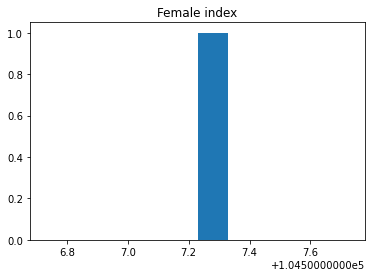

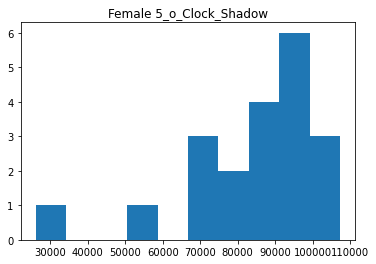

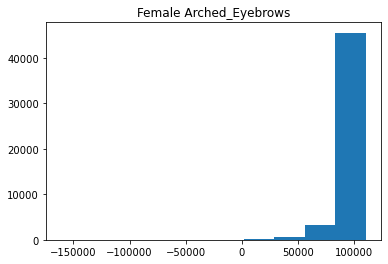

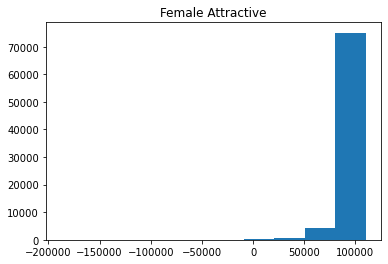

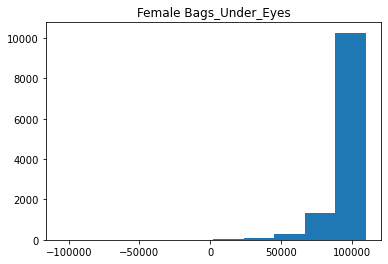

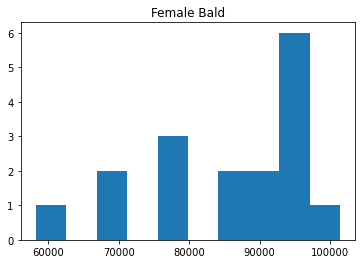

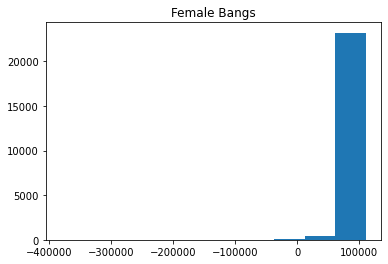

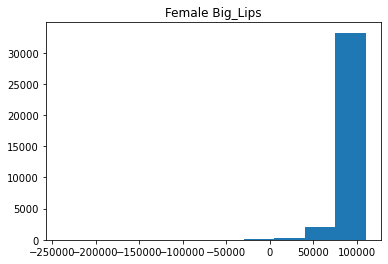

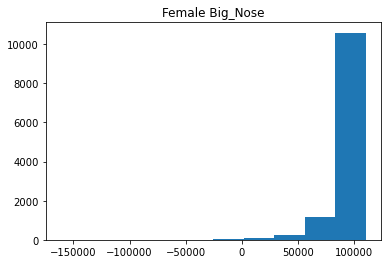

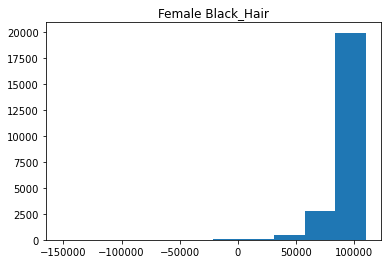

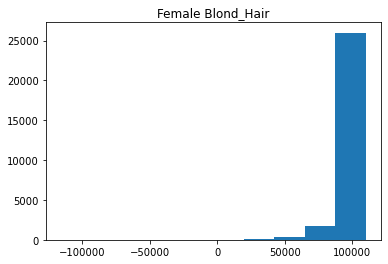

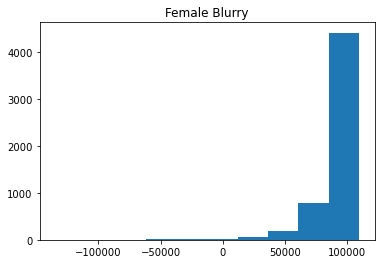

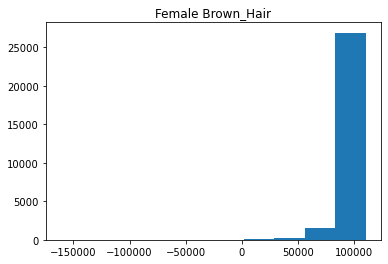

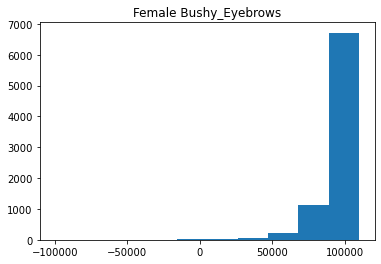

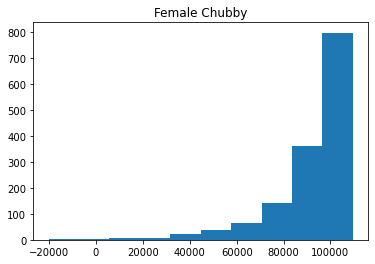

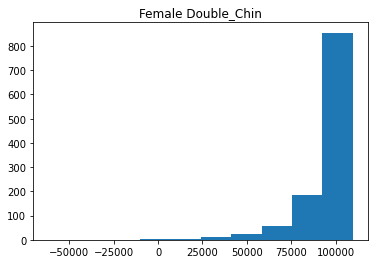

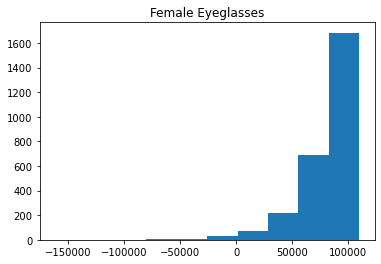

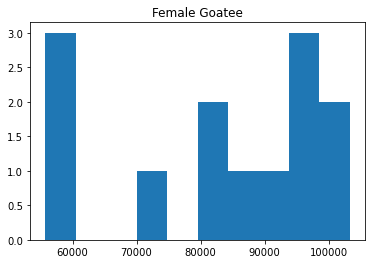

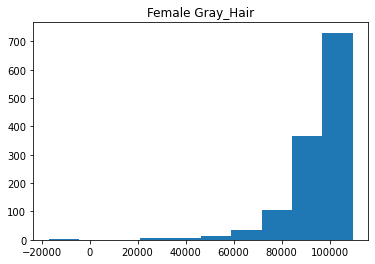

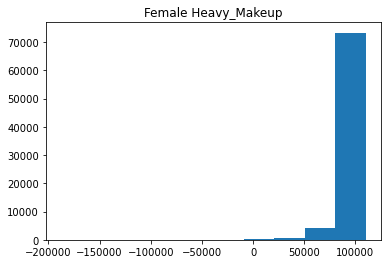

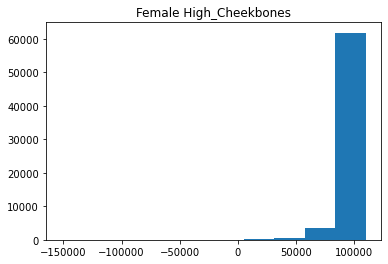

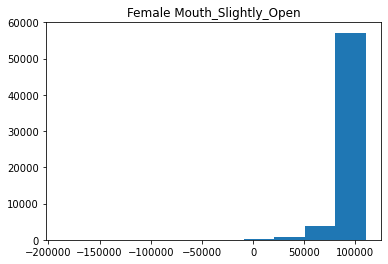

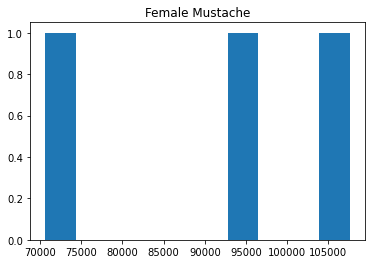

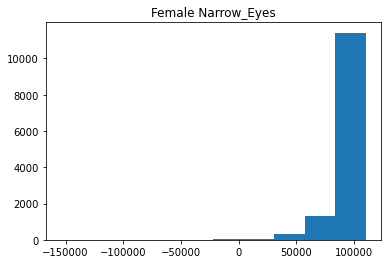

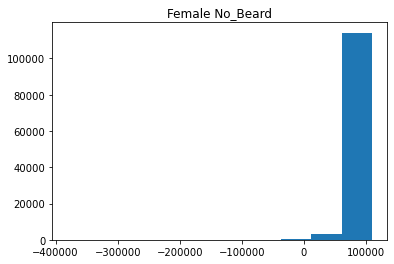

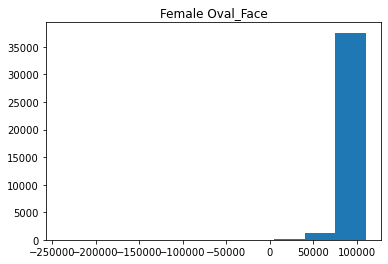

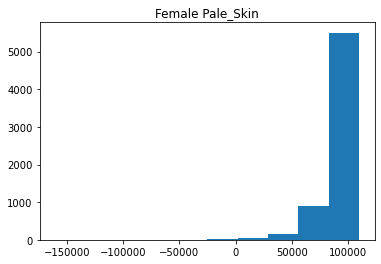

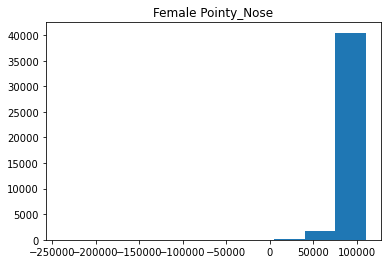

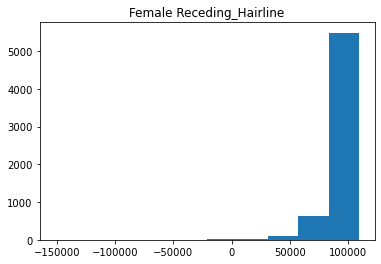

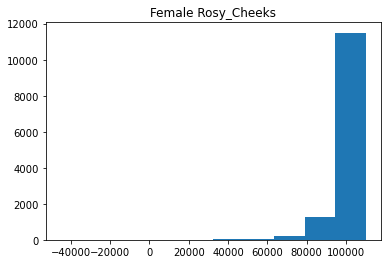

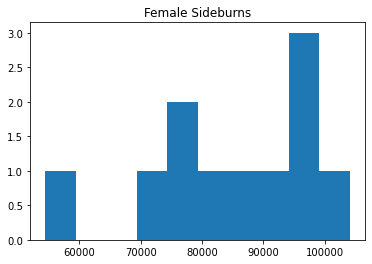

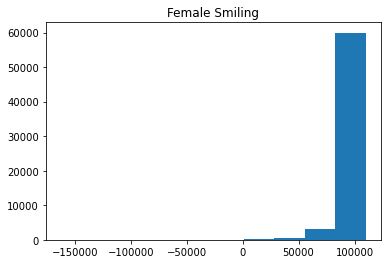

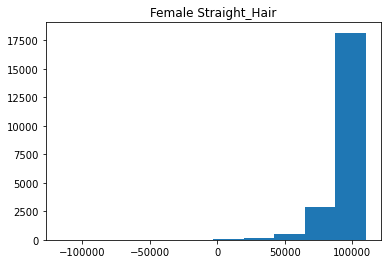

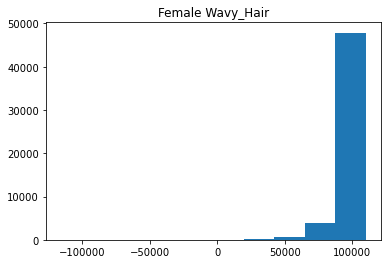

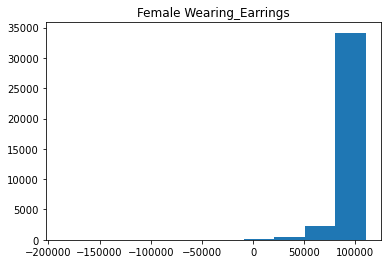

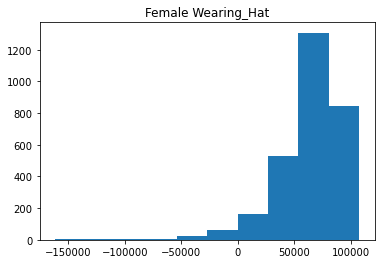

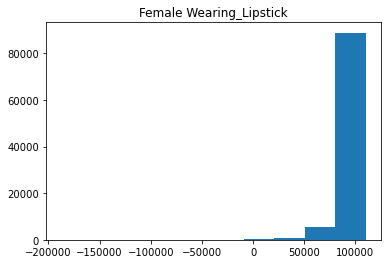

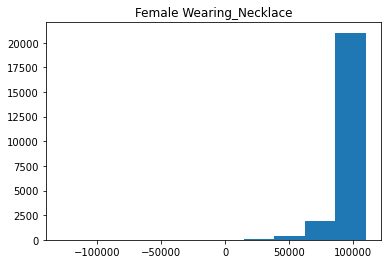

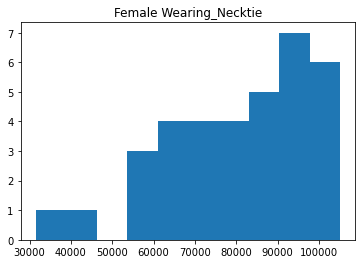

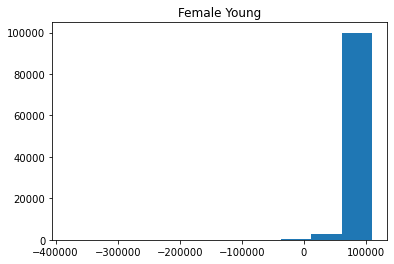

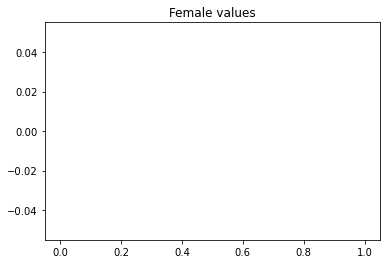

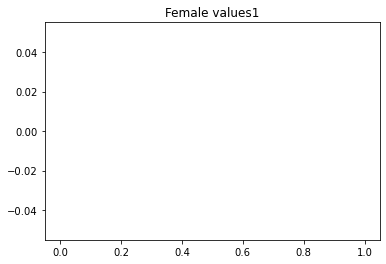

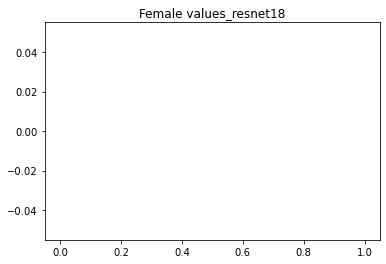

<Figure size 432x288 with 0 Axes>

In [37]:
df_gender = df[df["Male"] == -1]

gender = "Female"
for col in bias.keys():
    make_histograms(results_folder + "/histograms_celeba", df=df_gender,
                    col=col, score="values_resnet18", gender=gender)
    plt.clf()

In [38]:
bias.keys()

dict_keys(['index', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', 'values', 'values1', 'values_resnet18'])

We plot the top 36 images according to the ranking. 

In [39]:
def save_images_as_grid(path, array_img_vectors):

    array_img_vectors = torch.from_numpy(array_img_vectors)\
        .float().permute(0, 3, 1, 2)
    grid = make_grid(array_img_vectors, nrow=6, normalize=True)*255
    ndarr = grid.to('cpu', torch.uint8).numpy().T
    im = Image.fromarray(ndarr.transpose(1, 0, 2))

    #im.save(path)
    display(im)

In [40]:
img_ids = df[df["Male"] == -1].sort_values(by="values_resnet18", ascending=False)["image_id"][:36]
array_img_vectors = np.array(
    [skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
     for file in img_ids])

In [41]:
ind = df[df["Male"] == -1].sort_values(by="values_resnet18", ascending=False)["image_id"][:36].index
df[df["Male"] == -1].loc[ind, "Wearing_Hat"]

3892     -1
62870    -1
37216    -1
99314    -1
110494   -1
116428   -1
57010    -1
91523    -1
57211    -1
1566     -1
48038    -1
39388    -1
69652    -1
9925     -1
103181   -1
114493   -1
92847    -1
34556    -1
55990    -1
87809    -1
6856     -1
97509    -1
69190    -1
13592    -1
99359    -1
33997    -1
72340    -1
44168    -1
34473    -1
90221    -1
64814    -1
116405   -1
105282   -1
21487    -1
70798    -1
111572   -1
Name: Wearing_Hat, dtype: int64

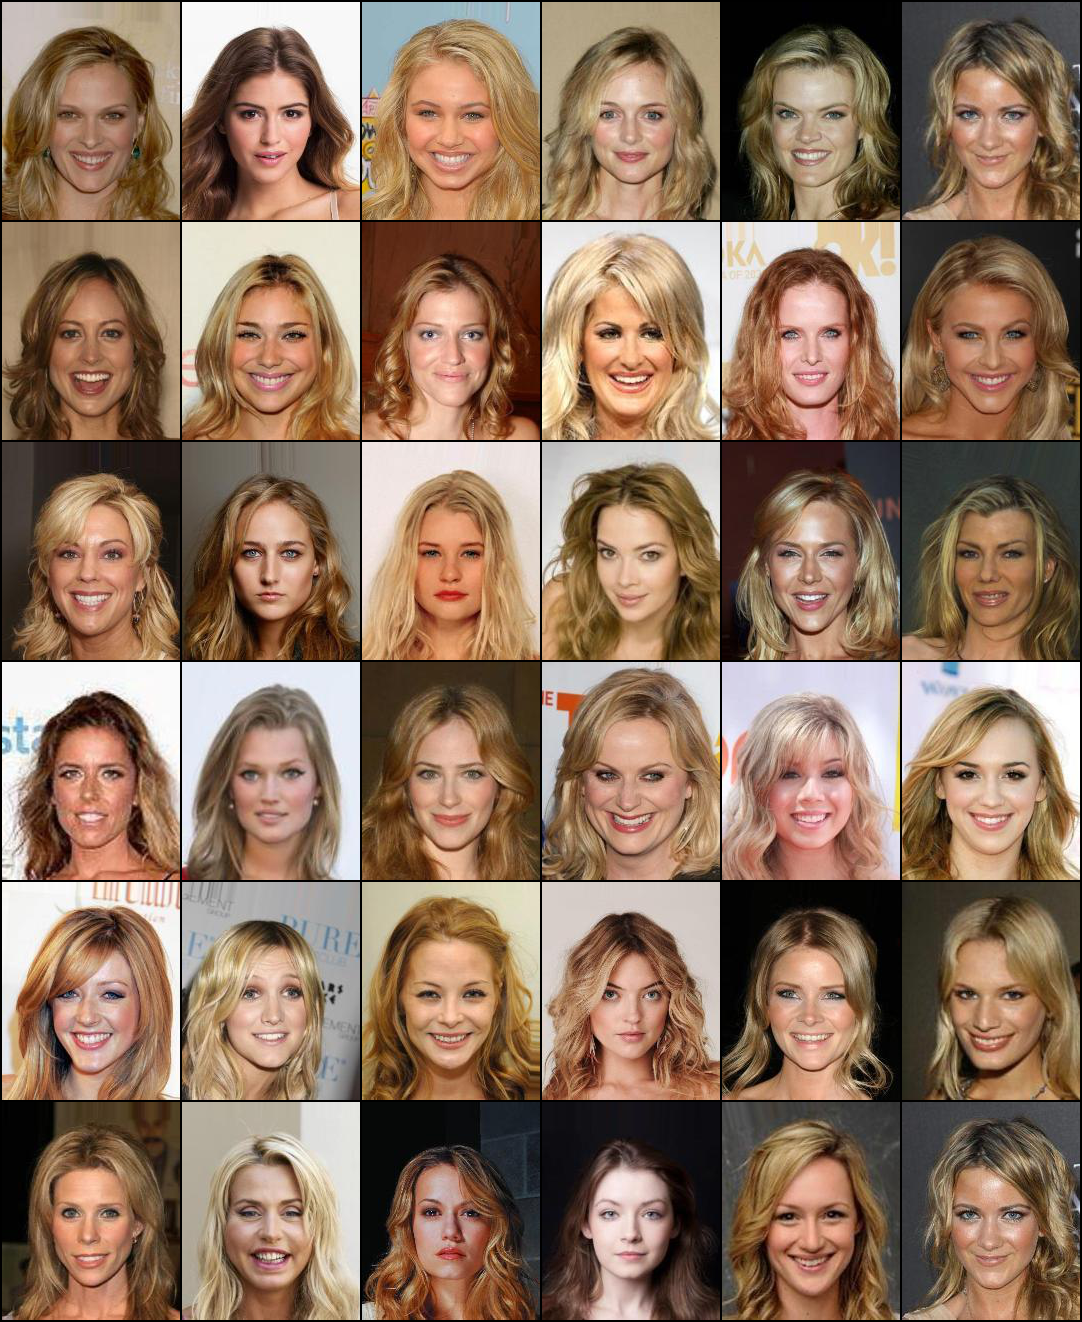

In [42]:
save_images_as_grid("", array_img_vectors)

We open the numpy array of our feature space

In [17]:
def open_array():
    pass

In [50]:
path_arr = '../results/Results_CelebA_ResNet18/input_dim_1000/init_trunc_inv_sqrt/layers_3/neuron_1024/lambda_cvx_0.1_mean_0.0/optim_Adamlr_0.001betas_0.5_0.99/gen_16/batch_25/trial_1_last_inp_qudr/feature_space.npy'
space = np.load(path_arr)
#space = np.random.randn(160, 512)

We plot the TSNE representation of our space. We distinguisce points sampled from the two distributions. The features extracted from female subjects are colered according to our ranking score.

In [46]:
def plot_tsne(path, array1, array2, scores):
    
    fig, ax = plt.subplots()
    
    sc1 = plt.scatter(array1[:,0], array1[:,1], marker="^", c="gray")
    sc2 = plt.scatter(array2[:,0], array2[:,1], marker="o",
                c=scores, cmap="plasma_r")
    plt.title("TSNE representation of the feature space")
    
    axcb = fig.colorbar(sc2)
    axcb.set_label('Ranking score')
    
    # plt.savefig(path + "/Tsne_plot.jpeg")
    plt.show()

In [47]:
sample = df.sample(10000)
sample_space = space[sample.index]
sample.reset_index(inplace=True)

sample_female = sample[sample["Male"] == -1].sample(500)
sample_female_score = sample_female["values_resnet18"].values
sample_female_array = sample_space[sample_female.index]


sample_male = sample[sample["Male"] == 1].sample(500)
sample_male_array = sample_space[sample_male.index]


tsne = TSNE()
transformed_space = tsne.fit_transform(sample_space)

/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/simonefabrizzi/anaconda3/envs/ot-bias/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


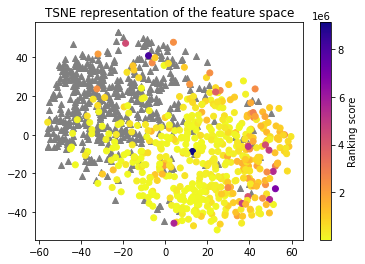

In [49]:
plot_tsne("",
          transformed_space[sample_male.index],
          transformed_space[sample_female.index],
          sample_female_score)

We cluster the features of the top 10% images according to the ranking and show the images that are the closest to the centroids. 

In [54]:
nintieth_quatile = df[df["Male"] == -1].values_resnet18.quantile(.9)

indeces = df[(df["Male"] == -1) & (df["values_resnet18"] >= nintieth_quatile)].index

to_cluster = space[indeces]

In [56]:
kmeans.cluster_centers_

array([[ 0.24542248,  1.3234451 ,  0.75425637, ..., -3.6656566 ,
         1.4433006 ,  3.4836373 ],
       [ 1.5903077 ,  0.7432894 ,  1.4207814 , ..., -3.3898478 ,
         1.194732  ,  2.8993895 ],
       [ 0.39759052,  0.8665465 ,  0.923121  , ..., -3.6218328 ,
         0.52789676,  2.7219548 ],
       ...,
       [ 2.9594417 ,  1.5846395 ,  2.2480414 , ..., -1.9001051 ,
         1.5228467 ,  3.2557566 ],
       [ 0.1037339 ,  0.51063377,  0.822659  , ..., -3.8597035 ,
         1.4199406 ,  2.4671056 ],
       [ 0.62433237,  1.1406858 ,  1.6074343 , ..., -3.6017938 ,
         1.9873252 ,  3.2752433 ]], dtype=float32)

In [62]:
kmeans = KMeans(n_clusters = 5)

kmeans.fit(to_cluster)

KMeans(n_clusters=5)

Centroid of cluster 0


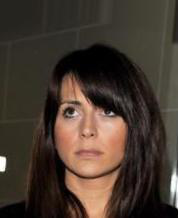

Centroid of cluster 1


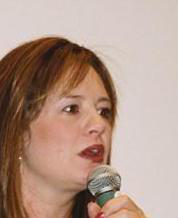

Centroid of cluster 2


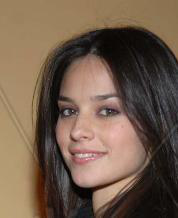

Centroid of cluster 3


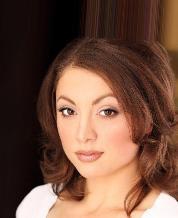

Centroid of cluster 4


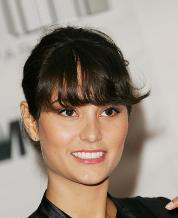

In [63]:
for i in set(kmeans.labels_):
    # select elements of the cluster
    elements = to_cluster[kmeans.labels_ == i]
    
    centroid = kmeans.cluster_centers_[i]
 
    minimum = elements[np.linalg.norm(elements - centroid, axis = 1).argmin()]

    to_print = np.linalg.norm(space - minimum, axis = 1).argmin()
    
    file = df.loc[to_print, "image_id"]
    image = skimage.io.imread("../data/celeba/Img_folder/Img/" + file)
    
    im = Image.fromarray(image)

    #im.save(path)
    print("Centroid of cluster {}".format(i))
    display(im)
    